In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 sample_submission.csv	X_val.npy
custom_fast_text_embeddings.npy  SelfAttention.py	y_test.npy
datalab				 train_model.py		y_train_full.npy
fast_text_embeddings.npy	 X_submission.npy	y_train.npy
plot_history.py			 X_test.npy		y_val.npy
__pycache__			 X_train_full.npy
roc_auc_callback.py		 X_train.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'15j1Nou6m5WNLejJQrUcty6U03xsIgIAI'})
file_import.GetContentFile('SelfAttention.py') 

from SelfAttention import SelfAttention

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def single_category_regressor(features, unitsNumber = 64):
    dense_1 = Dense(unitsNumber, activation = 'elu')(features)
    dense_1_normalization = BatchNormalization()(dense_1)
    dense_1_dropout = Dropout(0.2)(dense_1_normalization)

    dense_2 = Dense(unitsNumber, activation = 'elu')(dense_1_dropout)
    dense_2_normalization = BatchNormalization()(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2_normalization)
    
    return Dense(1, activation='sigmoid')(dense_2_dropout)

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

embedding_dropout = SelfAttention()(embedding_dropout)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor(filtersNumber, features_3)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

single_category_layer = concatenate([
    single_category_regressor(features, 128),
    single_category_regressor(features, 128),
    single_category_regressor(features, 128),
    single_category_regressor(features, 128),
    single_category_regressor(features, 128),
    single_category_regressor(features, 128),
])

output_layer = average([output_layer, single_category_layer])

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21376/102124 [=====>........................] - ETA: 8:24 - loss: 0.1761 - acc: 0.9287

102112/102124 [============================>.] - ETA: 0s - loss: 0.0959 - acc: 0.9637

102124/102124 [==============================] - 645s 6ms/step - loss: 0.0958 - acc: 0.9637 - val_loss: 0.0715 - val_acc: 0.9768
Epoch 2/32
 10144/102124 [=>............................] - ETA: 8:57 - loss: 0.0702 - acc: 0.9734

102112/102124 [============================>.] - ETA: 0s - loss: 0.0646 - acc: 0.9766

102124/102124 [==============================] - 636s 6ms/step - loss: 0.0646 - acc: 0.9766 - val_loss: 0.0531 - val_acc: 0.9802
roc-auc: 0.9462 - roc-auc_val: 0.9425                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 9:05 - loss: 0.0631 - acc: 0.9776

 49664/102124 [=============>................] - ETA: 5:06 - loss: 0.0606 - acc: 0.9775

102112/102124 [============================>.] - ETA: 0s - loss: 0.0583 - acc: 0.9786

102124/102124 [==============================] - 636s 6ms/step - loss: 0.0583 - acc: 0.9786 - val_loss: 0.0774 - val_acc: 0.9784
Epoch 4/32
 14048/102124 [===>..........................] - ETA: 8:34 - loss: 0.0537 - acc: 0.9806

102112/102124 [============================>.] - ETA: 0s - loss: 0.0536 - acc: 0.9803

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0536 - acc: 0.9803 - val_loss: 0.0471 - val_acc: 0.9819
roc-auc: 0.9805 - roc-auc_val: 0.9784                                                                                                    
Epoch 5/32
  8736/102124 [=>............................] - ETA: 9:06 - loss: 0.0492 - acc: 0.9818

 56768/102124 [===============>..............] - ETA: 4:25 - loss: 0.0511 - acc: 0.9808

 95712/102124 [===========================>..] - ETA: 37s - loss: 0.0510 - acc: 0.9809

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0507 - acc: 0.9810 - val_loss: 0.0463 - val_acc: 0.9823
Epoch 6/32
 11648/102124 [==>...........................] - ETA: 8:47 - loss: 0.0489 - acc: 0.9816

102112/102124 [============================>.] - ETA: 0s - loss: 0.0490 - acc: 0.9815

102124/102124 [==============================] - 636s 6ms/step - loss: 0.0490 - acc: 0.9815 - val_loss: 0.0546 - val_acc: 0.9822
roc-auc: 0.9847 - roc-auc_val: 0.981                                                                                                    
Epoch 7/32
  8768/102124 [=>............................] - ETA: 9:04 - loss: 0.0478 - acc: 0.9816

 82592/102124 [=======================>......] - ETA: 1:54 - loss: 0.0478 - acc: 0.9818

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0477 - acc: 0.9818 - val_loss: 0.0451 - val_acc: 0.9826
Epoch 8/32
  6592/102124 [>.............................] - ETA: 9:18 - loss: 0.0512 - acc: 0.9802

 69888/102124 [===================>..........] - ETA: 3:08 - loss: 0.0478 - acc: 0.9816

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0469 - acc: 0.9820 - val_loss: 0.0438 - val_acc: 0.9833
roc-auc: 0.9877 - roc-auc_val: 0.9816                                                                                                    
Epoch 9/32
  1056/102124 [..............................] - ETA: 9:50 - loss: 0.0506 - acc: 0.9800

 72800/102124 [====================>.........] - ETA: 2:51 - loss: 0.0455 - acc: 0.9823

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0454 - acc: 0.9823 - val_loss: 0.0430 - val_acc: 0.9831
Epoch 10/32
  2848/102124 [..............................] - ETA: 9:40 - loss: 0.0442 - acc: 0.9812

 68064/102124 [==================>...........] - ETA: 3:19 - loss: 0.0457 - acc: 0.9821

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0450 - acc: 0.9823 - val_loss: 0.0442 - val_acc: 0.9826
roc-auc: 0.9894 - roc-auc_val: 0.984                                                                                                    
Epoch 11/32
   640/102124 [..............................] - ETA: 9:48 - loss: 0.0533 - acc: 0.9784

102112/102124 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9826

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0441 - acc: 0.9826 - val_loss: 0.0432 - val_acc: 0.9833

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00017677669529803097.
Epoch 12/32
  8032/102124 [=>............................] - ETA: 9:10 - loss: 0.0431 - acc: 0.9831

 65952/102124 [==================>...........] - ETA: 3:31 - loss: 0.0434 - acc: 0.9826

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0436 - acc: 0.9827 - val_loss: 0.0413 - val_acc: 0.9839
roc-auc: 0.9908 - roc-auc_val: 0.9859                                                                                                    
Epoch 13/32
   160/102124 [..............................] - ETA: 9:59 - loss: 0.0391 - acc: 0.9812 

 98784/102124 [============================>.] - ETA: 19s - loss: 0.0429 - acc: 0.9830

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0430 - acc: 0.9830 - val_loss: 0.0492 - val_acc: 0.9818
Epoch 14/32
 12704/102124 [==>...........................] - ETA: 8:43 - loss: 0.0418 - acc: 0.9834

 76096/102124 [=====================>........] - ETA: 2:32 - loss: 0.0427 - acc: 0.9830

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0428 - acc: 0.9830 - val_loss: 0.0405 - val_acc: 0.9838
roc-auc: 0.9918 - roc-auc_val: 0.9871                                                                                                    
Epoch 15/32
  2528/102124 [..............................] - ETA: 9:43 - loss: 0.0394 - acc: 0.9850

 44608/102124 [============>.................] - ETA: 5:36 - loss: 0.0420 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9833

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0420 - acc: 0.9833 - val_loss: 0.0407 - val_acc: 0.9840
Epoch 16/32
 13984/102124 [===>..........................] - ETA: 8:35 - loss: 0.0425 - acc: 0.9832

 91584/102124 [=========================>....] - ETA: 1:01 - loss: 0.0419 - acc: 0.9832

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0417 - acc: 0.9834 - val_loss: 0.0411 - val_acc: 0.9839
roc-auc: 0.9921 - roc-auc_val: 0.9868                                                                                                    
Epoch 17/32
  6240/102124 [>.............................] - ETA: 9:20 - loss: 0.0410 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9835

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0414 - acc: 0.9835 - val_loss: 0.0409 - val_acc: 0.9837
Epoch 18/32
 13984/102124 [===>..........................] - ETA: 8:35 - loss: 0.0409 - acc: 0.9833

102112/102124 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9835

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0409 - acc: 0.9835 - val_loss: 0.0416 - val_acc: 0.9837
roc-auc: 0.992 - roc-auc_val: 0.9868                                                                                                    
Epoch 19/32
  8736/102124 [=>............................] - ETA: 9:06 - loss: 0.0378 - acc: 0.9848

 62880/102124 [=================>............] - ETA: 3:49 - loss: 0.0399 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9837

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0406 - acc: 0.9837 - val_loss: 0.0407 - val_acc: 0.9840
Epoch 20/32
 13952/102124 [===>..........................] - ETA: 8:35 - loss: 0.0424 - acc: 0.9829

102112/102124 [============================>.] - ETA: 0s - loss: 0.0404 - acc: 0.9835

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0404 - acc: 0.9835 - val_loss: 0.0407 - val_acc: 0.9839
roc-auc: 0.9925 - roc-auc_val: 0.9873                                                                                                    
Epoch 21/32
  8704/102124 [=>............................] - ETA: 9:07 - loss: 0.0396 - acc: 0.9841

 60480/102124 [================>.............] - ETA: 4:03 - loss: 0.0407 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9838

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0402 - acc: 0.9838 - val_loss: 0.0404 - val_acc: 0.9838
Epoch 22/32
 13984/102124 [===>..........................] - ETA: 8:35 - loss: 0.0405 - acc: 0.9834

102112/102124 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9837

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0402 - acc: 0.9837 - val_loss: 0.0408 - val_acc: 0.9835
roc-auc: 0.9932 - roc-auc_val: 0.9881                                                                                                    
Epoch 23/32
  8704/102124 [=>............................] - ETA: 9:05 - loss: 0.0404 - acc: 0.9836

101344/102124 [============================>.] - ETA: 4s - loss: 0.0399 - acc: 0.9838

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0399 - acc: 0.9838 - val_loss: 0.0402 - val_acc: 0.9841
Epoch 24/32
 13696/102124 [===>..........................] - ETA: 8:36 - loss: 0.0393 - acc: 0.9839

 54944/102124 [===============>..............] - ETA: 4:36 - loss: 0.0394 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0395 - acc: 0.9838

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0395 - acc: 0.9838 - val_loss: 0.0404 - val_acc: 0.9840
roc-auc: 0.9935 - roc-auc_val: 0.988                                                                                                    
Epoch 25/32
  8736/102124 [=>............................] - ETA: 9:05 - loss: 0.0375 - acc: 0.9845

 57856/102124 [===============>..............] - ETA: 4:19 - loss: 0.0388 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0393 - acc: 0.9839

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0393 - acc: 0.9839 - val_loss: 0.0402 - val_acc: 0.9841

Epoch 00025: ReduceLROnPlateau reducing learning rate to 4.123462349525653e-05.
Epoch 26/32
  8032/102124 [=>............................] - ETA: 9:10 - loss: 0.0381 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9839

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0392 - acc: 0.9839 - val_loss: 0.0400 - val_acc: 0.9841
roc-auc: 0.9938 - roc-auc_val: 0.988                                                                                                    
Epoch 27/32
  8736/102124 [=>............................] - ETA: 9:06 - loss: 0.0399 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0393 - acc: 0.9840

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0393 - acc: 0.9840 - val_loss: 0.0406 - val_acc: 0.9839
Epoch 28/32
 13984/102124 [===>..........................] - ETA: 8:34 - loss: 0.0394 - acc: 0.9836

 97824/102124 [===========================>..] - ETA: 25s - loss: 0.0389 - acc: 0.9840

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0389 - acc: 0.9840 - val_loss: 0.0403 - val_acc: 0.9840
roc-auc: 0.9931 - roc-auc_val: 0.988                                                                                                    
Epoch 29/32
  7712/102124 [=>............................] - ETA: 9:12 - loss: 0.0381 - acc: 0.9842

 67040/102124 [==================>...........] - ETA: 3:25 - loss: 0.0385 - acc: 0.9843

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0390 - acc: 0.9841 - val_loss: 0.0402 - val_acc: 0.9841
Epoch 30/32
   672/102124 [..............................] - ETA: 9:53 - loss: 0.0412 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9842

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0387 - acc: 0.9842 - val_loss: 0.0404 - val_acc: 0.9840
roc-auc: 0.994 - roc-auc_val: 0.9879                                                                                                    
Epoch 31/32
  8736/102124 [=>............................] - ETA: 9:06 - loss: 0.0390 - acc: 0.9844

101120/102124 [============================>.] - ETA: 5s - loss: 0.0387 - acc: 0.9842

102124/102124 [==============================] - 638s 6ms/step - loss: 0.0386 - acc: 0.9842 - val_loss: 0.0399 - val_acc: 0.9842
Epoch 32/32
 13632/102124 [===>..........................] - ETA: 8:37 - loss: 0.0381 - acc: 0.9840

 82336/102124 [=======================>......] - ETA: 1:55 - loss: 0.0383 - acc: 0.9842

102124/102124 [==============================] - 637s 6ms/step - loss: 0.0384 - acc: 0.9841 - val_loss: 0.0405 - val_acc: 0.9841
roc-auc: 0.9936 - roc-auc_val: 0.9878                                                                                                    


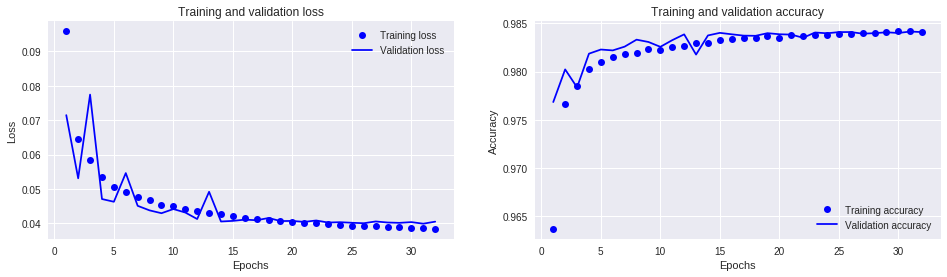

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 54s 2ms/step
([0.03904805236579052, 0.9844325951997266], 0.9887954630362753)


Medium batch size training

In [13]:
history = train_with_cv(model, batchSize=64, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 42816/102124 [===========>..................] - ETA: 5:10 - loss: 0.1556 - acc: 0.9312

102124/102124 [==============================] - 563s 6ms/step - loss: 0.1086 - acc: 0.9548 - val_loss: 0.1086 - val_acc: 0.9703
Epoch 2/32
  5376/102124 [>.............................] - ETA: 8:09 - loss: 0.0685 - acc: 0.9734

102080/102124 [============================>.] - ETA: 0s - loss: 0.0650 - acc: 0.9758

102124/102124 [==============================] - 554s 5ms/step - loss: 0.0650 - acc: 0.9758 - val_loss: 0.9354 - val_acc: 0.4094
roc-auc: 0.7373 - roc-auc_val: 0.7351                                                                                                    
Epoch 3/32
 17408/102124 [====>.........................] - ETA: 7:06 - loss: 0.0610 - acc: 0.9781

102080/102124 [============================>.] - ETA: 0s - loss: 0.0563 - acc: 0.9789

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0563 - acc: 0.9789 - val_loss: 0.0597 - val_acc: 0.9794
Epoch 4/32
 20352/102124 [====>.........................] - ETA: 6:52 - loss: 0.0514 - acc: 0.9805

102080/102124 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9805

102124/102124 [==============================] - 554s 5ms/step - loss: 0.0518 - acc: 0.9805 - val_loss: 0.0454 - val_acc: 0.9825
roc-auc: 0.9847 - roc-auc_val: 0.9813                                                                                                    
Epoch 5/32
 17408/102124 [====>.........................] - ETA: 7:06 - loss: 0.0485 - acc: 0.9815

102080/102124 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.9809

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0495 - acc: 0.9809 - val_loss: 0.0446 - val_acc: 0.9828
Epoch 6/32
 20352/102124 [====>.........................] - ETA: 6:52 - loss: 0.0462 - acc: 0.9819

102080/102124 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9813

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0482 - acc: 0.9813 - val_loss: 0.0426 - val_acc: 0.9834
roc-auc: 0.9878 - roc-auc_val: 0.9845                                                                                                    
Epoch 7/32
 17408/102124 [====>.........................] - ETA: 7:06 - loss: 0.0468 - acc: 0.9819

102080/102124 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9817

102124/102124 [==============================] - 554s 5ms/step - loss: 0.0467 - acc: 0.9817 - val_loss: 0.0445 - val_acc: 0.9823
Epoch 8/32
 20352/102124 [====>.........................] - ETA: 6:52 - loss: 0.0451 - acc: 0.9822

102080/102124 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9822

102124/102124 [==============================] - 554s 5ms/step - loss: 0.0455 - acc: 0.9822 - val_loss: 0.0530 - val_acc: 0.9811

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00024148408556357026.
roc-auc: 0.9758 - roc-auc_val: 0.9761                                                                                                    
Epoch 9/32
 11840/102124 [==>...........................] - ETA: 7:35 - loss: 0.0440 - acc: 0.9824

102080/102124 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9824

102124/102124 [==============================] - 554s 5ms/step - loss: 0.0446 - acc: 0.9824 - val_loss: 0.0587 - val_acc: 0.9794
Epoch 10/32
 20288/102124 [====>.........................] - ETA: 6:52 - loss: 0.0423 - acc: 0.9831

102080/102124 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9825

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0438 - acc: 0.9825 - val_loss: 0.0697 - val_acc: 0.9798
roc-auc: 0.9558 - roc-auc_val: 0.9485                                                                                                    
Epoch 11/32
 17344/102124 [====>.........................] - ETA: 7:07 - loss: 0.0432 - acc: 0.9825

102080/102124 [============================>.] - ETA: 0s - loss: 0.0428 - acc: 0.9829

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0428 - acc: 0.9829 - val_loss: 0.0536 - val_acc: 0.9818
Epoch 12/32
 20288/102124 [====>.........................] - ETA: 6:52 - loss: 0.0430 - acc: 0.9825

102080/102124 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9830

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0424 - acc: 0.9830 - val_loss: 0.0408 - val_acc: 0.9840
roc-auc: 0.9917 - roc-auc_val: 0.9864                                                                                                    
Epoch 13/32
 17344/102124 [====>.........................] - ETA: 7:07 - loss: 0.0418 - acc: 0.9829

102080/102124 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9833

102124/102124 [==============================] - 554s 5ms/step - loss: 0.0414 - acc: 0.9833 - val_loss: 0.0408 - val_acc: 0.9841
Epoch 14/32
 20288/102124 [====>.........................] - ETA: 6:52 - loss: 0.0428 - acc: 0.9823

102080/102124 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9832

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0411 - acc: 0.9832 - val_loss: 0.0408 - val_acc: 0.9840
roc-auc: 0.9924 - roc-auc_val: 0.9873                                                                                                    
Epoch 15/32
 17344/102124 [====>.........................] - ETA: 7:06 - loss: 0.0413 - acc: 0.9834

102080/102124 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9834

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0406 - acc: 0.9834 - val_loss: 0.0403 - val_acc: 0.9841
Epoch 16/32
 20288/102124 [====>.........................] - ETA: 6:52 - loss: 0.0401 - acc: 0.9832

102080/102124 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9837

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0400 - acc: 0.9837 - val_loss: 0.0545 - val_acc: 0.9814
roc-auc: 0.9786 - roc-auc_val: 0.9745                                                                                                    
Epoch 17/32
 17344/102124 [====>.........................] - ETA: 7:07 - loss: 0.0389 - acc: 0.9837

102080/102124 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9838

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0397 - acc: 0.9838 - val_loss: 0.0400 - val_acc: 0.9841
Epoch 18/32
 20288/102124 [====>.........................] - ETA: 6:52 - loss: 0.0394 - acc: 0.9838

102080/102124 [============================>.] - ETA: 0s - loss: 0.0395 - acc: 0.9839

102124/102124 [==============================] - 554s 5ms/step - loss: 0.0395 - acc: 0.9839 - val_loss: 0.0404 - val_acc: 0.9842
roc-auc: 0.9933 - roc-auc_val: 0.9872                                                                                                    
Epoch 19/32
 17344/102124 [====>.........................] - ETA: 7:07 - loss: 0.0387 - acc: 0.9844

102080/102124 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9843

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0387 - acc: 0.9843 - val_loss: 0.0405 - val_acc: 0.9842

Epoch 00019: ReduceLROnPlateau reducing learning rate to 7.694652595091611e-05.
Epoch 20/32
 16064/102124 [===>..........................] - ETA: 7:12 - loss: 0.0368 - acc: 0.9850

102080/102124 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9843

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0383 - acc: 0.9843 - val_loss: 0.0406 - val_acc: 0.9843
roc-auc: 0.9923 - roc-auc_val: 0.9853                                                                                                    
Epoch 21/32
 17344/102124 [====>.........................] - ETA: 7:07 - loss: 0.0388 - acc: 0.9840

102080/102124 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9844

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0381 - acc: 0.9844 - val_loss: 0.0401 - val_acc: 0.9844
Epoch 22/32
 20288/102124 [====>.........................] - ETA: 6:51 - loss: 0.0374 - acc: 0.9846

102080/102124 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9843

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0378 - acc: 0.9843 - val_loss: 0.0403 - val_acc: 0.9843
roc-auc: 0.9946 - roc-auc_val: 0.9875                                                                                                    
Epoch 23/32
 17344/102124 [====>.........................] - ETA: 7:07 - loss: 0.0371 - acc: 0.9846

102080/102124 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9846

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0373 - acc: 0.9846 - val_loss: 0.0404 - val_acc: 0.9843
Epoch 24/32
 20288/102124 [====>.........................] - ETA: 6:52 - loss: 0.0363 - acc: 0.9848

102080/102124 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9846

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0376 - acc: 0.9846 - val_loss: 0.0406 - val_acc: 0.9842
roc-auc: 0.9943 - roc-auc_val: 0.9868                                                                                                    
Epoch 25/32
 17344/102124 [====>.........................] - ETA: 7:07 - loss: 0.0373 - acc: 0.9847

102080/102124 [============================>.] - ETA: 0s - loss: 0.0370 - acc: 0.9846

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0370 - acc: 0.9846 - val_loss: 0.0404 - val_acc: 0.9844
Epoch 26/32
 20288/102124 [====>.........................] - ETA: 6:52 - loss: 0.0354 - acc: 0.9854

102080/102124 [============================>.] - ETA: 0s - loss: 0.0370 - acc: 0.9848

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0370 - acc: 0.9848 - val_loss: 0.0407 - val_acc: 0.9844
roc-auc: 0.9942 - roc-auc_val: 0.986                                                                                                    
Epoch 27/32
 17408/102124 [====>.........................] - ETA: 7:05 - loss: 0.0368 - acc: 0.9849

102080/102124 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9849

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0365 - acc: 0.9848 - val_loss: 0.0405 - val_acc: 0.9844


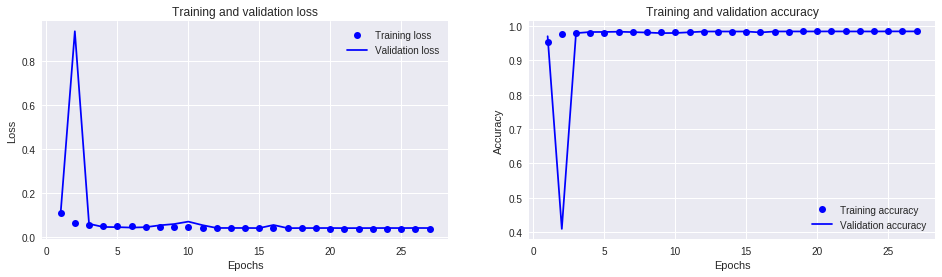

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 54s 2ms/step
([0.03869229166615435, 0.9848190362244662], 0.9894000107237372)
